# Notebook: Multi-Label Data Imbalance Image Classification

This notebook focuses on the image classification part of the task.

## Import Libraries

In [1]:
# change the python's path to the parent directory
import sys
sys.path.append("../")

In [2]:
import torch
import torch.nn as nn

from models.popular_models import PopularModels
from torch.utils.data import DataLoader
from torchvision import transforms, models
from data.dataset import MultiLabelDataset
from tqdm import tqdm
from tools.tools import get_data, load_data, remove_class

## Import Data

### Class Labels

There are 19 classes: class starts from 1 to 19. There is no label 12 assigned to any image. <br>
For one-hot encoding: the 0-the index will represent class 1.

In [3]:
# import data
train_data = get_data("../dataset/train.csv")
test_data = get_data("../dataset/test.csv")

# perform text cleaning and get the pandas' dataframe
train_data = load_data(train_data)
test_data = load_data(test_data, has_label=False)

In [4]:
print(f"Number of training instances: {train_data.shape[0]}")
print(f"Number of testing instances:  {test_data.shape[0]}")

Number of training instances: 30000
Number of testing instances:  10000


### Remove instances with only class 1 (Data Imbalance Problem)

In [5]:
# remove an imbalanced class
train_data = remove_class(train_data, class_no=1)
print(f"Number of training instances: {train_data.shape[0]}")

Number of training instances: 15925


## Preprocessing for Images and Caption

In [6]:
# define the image transformation: currently following resnet18
transform = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # converts images to [0, 1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

## Create Dataset and DataLoader

In [7]:
# initialize the dataset
train_dataset = MultiLabelDataset(
    csv_file=train_data,
    root_dir='../dataset/data/',
    vectorizer=None,
    transform=transform,
    use_caption_vec=False,
    caption_vec=None,
    is_test=False,
)
test_dataset = MultiLabelDataset(
    csv_file=test_data,
    root_dir='../dataset/data/',
    vectorizer=None,
    transform=transform,
    use_caption_vec=False,
    caption_vec=None,
    is_test=True,
)

BATCH_SIZE=16

# load the dataset into batches 
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## Define Model, Optimizer, Loss Function, etc.

In [8]:
N_OUT = 19

model = PopularModels(
    choice="regnet_x_1_6gf",
    pretrained=True,
    freeze=True,
    n_out=N_OUT,
).get_model()

# define hyperparameters
EPOCHS = 10
THRESHOLD = 0.5
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')

using GPU


## Perform Training

In [9]:
train_losses = []
train_accs = []
for epoch in range(EPOCHS):

	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for _, images, _, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			images = images.to('cuda')
			labels = labels.to('cuda')

		optimizer.zero_grad()
		y_pred = model(images)

		# backward
		loss = loss_fn(y_pred, labels)
		loss.backward()

		# update
		optimizer.step()

		# compare
		predicted = (y_pred > THRESHOLD).int()

		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

	train_losses.append(train_loss / len(train_dataloader))
	train_accs.append(n_correct / n_total)

	print("Epoch {:d}, Train Loss: {:.7f}, Train Accuracy: {:.3f}%".format(epoch+1, train_losses[-1], train_accs[-1]*100))

Epoch 1 Training:   0%|          | 0/996 [00:00<?, ?it/s]/home/reynardo/USYD/COMP4329/ASSIGNMENT 2/my_code/notebooks/../data/dataset.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.Tensor(self.df.iloc[idx, 2:])
Epoch 1 Training: 100%|██████████| 996/996 [01:05<00:00, 15.28it/s]


Epoch 1, Train Loss: 0.2097420, Train Accuracy: 13.940%


Epoch 2 Training: 100%|██████████| 996/996 [01:04<00:00, 15.36it/s]


Epoch 2, Train Loss: 0.1760471, Train Accuracy: 23.535%


Epoch 3 Training: 100%|██████████| 996/996 [01:04<00:00, 15.47it/s]


Epoch 3, Train Loss: 0.1692237, Train Accuracy: 25.777%


Epoch 4 Training: 100%|██████████| 996/996 [01:04<00:00, 15.42it/s]


Epoch 4, Train Loss: 0.1652702, Train Accuracy: 26.750%


Epoch 5 Training: 100%|██████████| 996/996 [01:04<00:00, 15.36it/s]


Epoch 5, Train Loss: 0.1630805, Train Accuracy: 27.780%


Epoch 6 Training: 100%|██████████| 996/996 [01:04<00:00, 15.42it/s]


Epoch 6, Train Loss: 0.1615190, Train Accuracy: 28.094%


Epoch 7 Training: 100%|██████████| 996/996 [01:04<00:00, 15.43it/s]


Epoch 7, Train Loss: 0.1600760, Train Accuracy: 28.647%


Epoch 8 Training: 100%|██████████| 996/996 [01:05<00:00, 15.24it/s]


Epoch 8, Train Loss: 0.1590998, Train Accuracy: 28.659%


Epoch 9 Training: 100%|██████████| 996/996 [01:04<00:00, 15.43it/s]


Epoch 9, Train Loss: 0.1575856, Train Accuracy: 29.181%


Epoch 10 Training: 100%|██████████| 996/996 [01:04<00:00, 15.45it/s]

Epoch 10, Train Loss: 0.1570701, Train Accuracy: 29.350%


In [10]:
import matplotlib.pyplot as plt

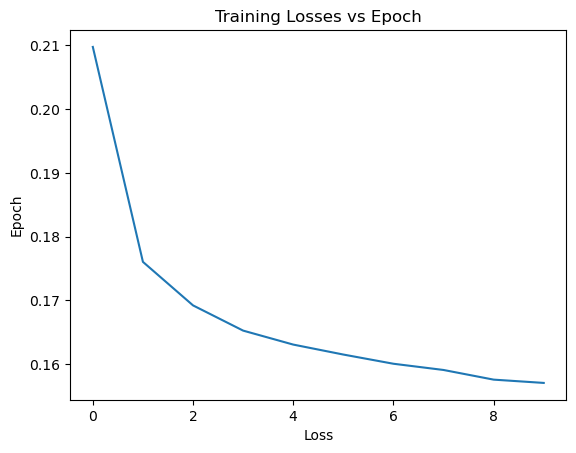

In [11]:
plt.title("Training Losses vs Epoch")
plt.plot(train_losses)
plt.ylabel("Epoch")
plt.xlabel("Loss")
plt.show()

## 

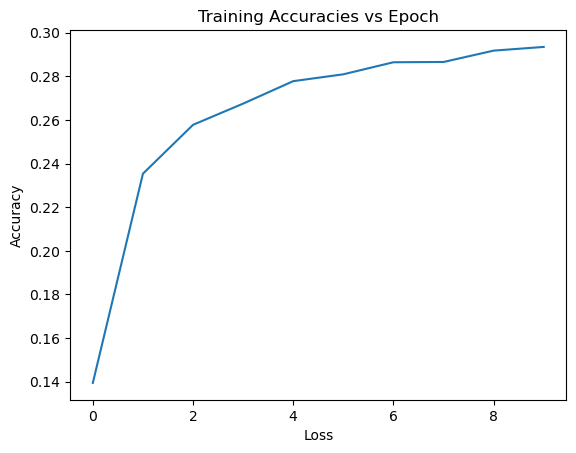

: 

In [15]:
new_train_accs = []
for train_acc in train_accs:
    new_train_accs.append(train_acc.item())

plt.title("Training Accuracies vs Epoch")
plt.plot(new_train_accs)
plt.ylabel("Accuracy")
plt.xlabel("Loss")
plt.show()

## Multi-Label Image Classification

Tutorials:
- [Build First Multi-Label Image Classification Model Python](https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/)